In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

import gym
import torch
import d4rl
import tqdm

from collections import defaultdict


No module named 'flow'
/home/jlr429/miniconda3/envs/orl/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Dec  1 2021 18:34:28


In [2]:
env_name = "antmaze-large-diverse-v2"

In [3]:
def foo(env_name):
    env = gym.make(env_name)
    dataset = env.get_dataset()
    term = np.argwhere(
        np.logical_or(dataset["timeouts"] > 0, dataset["terminals"] > 0)
    )
    start = 0
    expert_ranges = []
    for i in range(len(term)):
        expert_ranges.append([start, term[i][0] + 1])
        start = term[i][0] + 1
    expert_ranges = np.array(expert_ranges)
    obs_start = []
    obs_end = []
    goals = []
    for exp_range in expert_ranges:
        obs_start.append(dataset["observations"][exp_range[0]])
        obs_end.append(dataset["observations"][exp_range[1] - 1])
        goals.append(dataset["infos/goal"][exp_range[0]])

    return dataset["observations"], obs_start, obs_end, np.array(goals)

    

In [4]:
observations, *_ = foo("antmaze-large-play-v2")
print(np.min(observations, axis=0))
print(np.min(observations, axis=0))

/home/jlr429/miniconda3/envs/orl/lib/python3.9/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Target Goal:  (32.47666298060179, 24.823872215137055)


load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


[-1.3168952  -1.3257453   0.19217855 -0.99887025 -0.9998124  -0.999665
 -0.99998164 -0.66586584 -0.09988881 -0.66710204 -1.3399112  -0.6679479
 -1.3404989  -0.66734135 -0.09993137 -3.5724633  -3.8828814  -4.0584273
 -6.738492   -7.187218   -6.2540493  -7.4956455  -6.4558578  -7.4988756
 -8.507271   -7.5533442  -7.244853   -7.5233574  -6.3107567 ]
[-1.3168952  -1.3257453   0.19217855 -0.99887025 -0.9998124  -0.999665
 -0.99998164 -0.66586584 -0.09988881 -0.66710204 -1.3399112  -0.6679479
 -1.3404989  -0.66734135 -0.09993137 -3.5724633  -3.8828814  -4.0584273
 -6.738492   -7.187218   -6.2540493  -7.4956455  -6.4558578  -7.4988756
 -8.507271   -7.5533442  -7.244853   -7.5233574  -6.3107567 ]


In [5]:
# env_name = "antmaze-large-diverse-v2"
env_name = "antmaze-large-play-v2"
observation, obs_start, obs_end, goals = foo(env_name)
# observation = observation[:1000]
# obs_start = obs_start[:1000]
# obs_end = obs_end[:1000]
# goals = goals[:1000]

# get x, y from observations
x = observation[:, 0]
y = observation[:, 1]

# plot goal on top of density plot
gx, gy = goals[:, 0], goals[:, 1]

obs_start, obs_end = np.array(obs_start), np.array(obs_end)
start_x, start_y = obs_start[:, 0], obs_start[:, 1]
end_x, end_y = obs_end[:, 0], obs_end[:, 1]

Target Goal:  (33.085705343280836, 24.98447170544962)


load datafile:   0%|          | 0/8 [00:00<?, ?it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


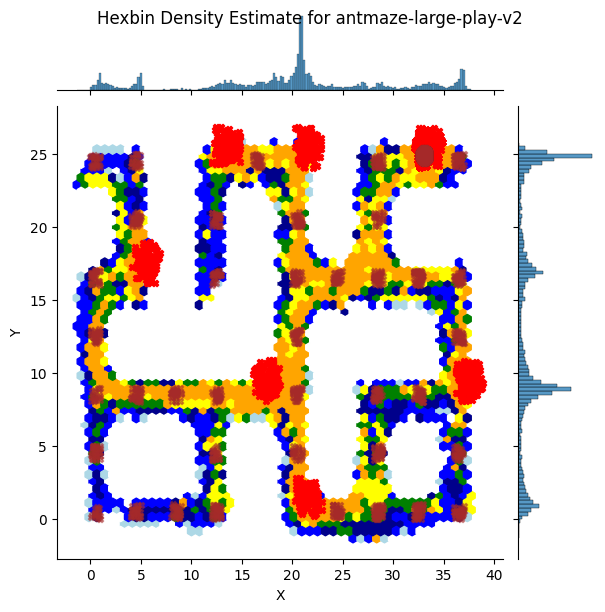

In [6]:
import matplotlib.colors as mcolors

# Define a custom colormap with distinct colors for different density levels
cmap = mcolors.ListedColormap(['white', 'lightblue', 'blue', 'darkblue', 'green', 'yellow', 'orange'])
bounds = [0, 5, 10, 50, 100, 200, 500, np.inf]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Uncomment the following lines if you want to add scatter plots for goal, start, and end points
g = sns.jointplot(x=x, y=y, kind="hex", gridsize=50, cmap=cmap, norm=norm)
# g = sns.jointplot(x=x, y=y, kind="hex", gridsize=50)
plt.scatter(gx, gy, color="red", s=20, marker="X")
plt.scatter(start_x, start_y, color="brown", s=20, marker="X", alpha=0.5)
# plt.scatter(end_x, end_y, color="orange", s=20, marker="X", alpha=0.5)

g.fig.suptitle(f"Hexbin Density Estimate for {env_name}")
g.set_axis_labels("X", "Y")
# g.fig.savefig(f"{env_name}_hexbin.png")

In [7]:
def sample_data_uniform(x, y, sample_ratio=0.2, bins=50):
    # Create a 2D histogram with the same binning as the hexbin plot
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Digitize the data points
    x_dig = np.digitize(x, xedges) - 1
    y_dig = np.digitize(y, yedges) - 1

    # Ensure the indices are within the valid range
    x_dig = np.clip(x_dig, 0, hist.shape[0] - 1)
    y_dig = np.clip(y_dig, 0, hist.shape[1] - 1)

    # Identify the bins with probability mass
    bins_with_mass = np.argwhere(hist > 0)

    # Calculate the total number of samples and the number of samples per bin
    total_samples = int(sample_ratio * len(x))
    num_bins = len(bins_with_mass)
    samples_per_bin = total_samples // num_bins

    # For each bin with mass, sample uniformly from the data points within that bin
    sampled_indices = []
    for bin_x, bin_y in bins_with_mass:
        bin_mask = (x_dig == bin_x) & (y_dig == bin_y)
        bin_indices = np.where(bin_mask)[0]
        num_samples = min(samples_per_bin, len(bin_indices))
        sampled_indices.extend(np.random.choice(bin_indices, size=num_samples, replace=False))

    # If there are not enough samples, sample more from the bins with mass
    while len(sampled_indices) < total_samples:
        bin_index = np.random.choice(num_bins)
        bin_x, bin_y = bins_with_mass[bin_index]
        bin_mask = (x_dig == bin_x) & (y_dig == bin_y)
        bin_indices = np.where(bin_mask)[0]
        if len(bin_indices) > 0:
            sampled_indices.append(np.random.choice(bin_indices))

    # Create a mask for the sampled data points
    sampled_mask = np.zeros(len(x), dtype=bool)
    sampled_mask[sampled_indices] = True

    # Select the sampled and remaining data points
    sampled_x = x[sampled_mask]
    sampled_y = y[sampled_mask]
    remaining_x = x[~sampled_mask]
    remaining_y = y[~sampled_mask]

    return sampled_x, sampled_y, remaining_x, remaining_y

In [8]:
def sample_data_balanced(x, y, bins=50, sample_ratio=0.2):
    # Create a 2D histogram with the same binning as the hexbin plot
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Digitize the data points
    x_dig = np.digitize(x, xedges) - 1
    y_dig = np.digitize(y, yedges) - 1

    # Ensure the indices are within the valid range
    x_dig = np.clip(x_dig, 0, hist.shape[0] - 1)
    y_dig = np.clip(y_dig, 0, hist.shape[1] - 1)

    # Create a dictionary to store the indices of the data points in each bin
    bin_indices = defaultdict(list)
    for i, (bin_x, bin_y) in enumerate(zip(x_dig, y_dig)):
        if hist[bin_x, bin_y] > 0:
            bin_indices[(bin_x, bin_y)].append(i)

    # For each bin, sample a certain ratio of the data points
    sampled_indices = []
    for bin_data_indices in bin_indices.values():
        if len(bin_data_indices) == 0:
            continue
        num_samples = int(len(bin_data_indices) * sample_ratio)
        sampled_indices.extend(np.random.choice(bin_data_indices, size=num_samples, replace=False))

    # Create a mask for the sampled data points
    sampled_mask = np.zeros(len(x), dtype=bool)
    sampled_mask[sampled_indices] = True

    # Select the sampled and remaining data points
    sampled_x = x[sampled_mask]
    sampled_y = y[sampled_mask]
    remaining_x = x[~sampled_mask]
    remaining_y = y[~sampled_mask]

    return sampled_x, sampled_y, remaining_x, remaining_y

In [9]:
def calculate_statistics(data_x, data_y):
    # Calculate the histogram
    hist, xedges, yedges = np.histogram2d(data_x, data_y, bins=50)

    # Filter out 0 values
    hist = hist[hist > 0]

    # Calculate the statistics
    data_min = np.min(hist)
    data_max = np.max(hist)
    data_median = np.median(hist)
    data_q1 = np.percentile(hist, 25)
    data_q3 = np.percentile(hist, 75)
    data_min_q1_median = np.median(hist[(hist >= data_min) & (hist <= data_q1)])
    data_q1_median = np.median(hist[(hist >= data_q1) & (hist <= data_median)])
    data_median_q3 = np.median(hist[(hist >= data_median) & (hist <= data_q3)])
    data_q3_max = np.median(hist[(hist >= data_q3) & (hist <= data_max)])

    # Return the statistics as a list
    return [data_min, data_min_q1_median, data_q1, data_q1_median, data_median, data_median_q3, data_q3, data_q3_max, data_max]

# # Calculate the statistics for sampled data
# sampled_data = calculate_statistics(sampled_x, sampled_y)
# print(f"Sampled data: {sampled_data}")

# # Calculate the statistics for remaining data
# remaining_data = calculate_statistics(remaining_x, remaining_y)
# print(f"Remaining data: {remaining_data}")

In [10]:
# Pretty Plots
import matplotlib
from matplotlib import font_manager as fm, pyplot as plt
!wget 'https://github.com/dolbydu/font/raw/master/Serif/Palatino/Palatino%20Linotype.ttf'
# Pick up any fonts in the current directory.
# If you do end up downloading the fonts to /usr/share/fonts/truetype,
# change this to: fm.findSystemFonts()
font_files = fm.findSystemFonts('.')
# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
 fm.fontManager.addfont(font_file)
# Use your new font on all your plots.
matplotlib.rc('font', family='Palatino Linotype')
def setup_plot():
 fig = plt.figure(dpi=100, figsize=(5.0,3.0))
 ax = plt.subplot(111)
 ax.spines['right'].set_visible(False)
 ax.spines['top'].set_visible(False)
 ax.yaxis.set_ticks_position('left')
 ax.xaxis.set_ticks_position('bottom')
 ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
 ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
 ax.tick_params(direction='in')

--2024-02-02 03:07:50--  https://github.com/dolbydu/font/raw/master/Serif/Palatino/Palatino%20Linotype.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/dolbydu/font/master/Serif/Palatino/Palatino%20Linotype.ttf [following]
--2024-02-02 03:07:50--  https://raw.githubusercontent.com/dolbydu/font/master/Serif/Palatino/Palatino%20Linotype.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 472664 (462K) [application/octet-stream]
Saving to: ‘Palatino Linotype.ttf.2’

Palatino Linotype.t 100%[===================>] 461.59K  --.-KB/s    in 0.03s   

2024-02-02 03:07:51 (17.6 MB/s) - ‘Palatino Linotype.ttf.2’ saved [472664/472664]



1000000, 1000000, 0, 0


/tmp/ipykernel_3710212/670748750.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_under("white")


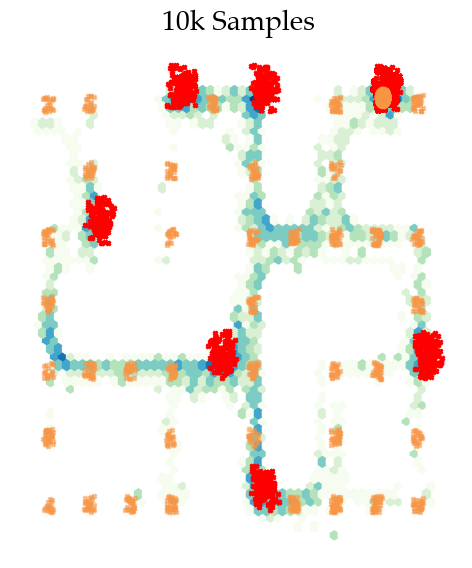

In [11]:
from numpy import size


val_x, val_y, train_x, train_y = sample_data_balanced(x, y, sample_ratio=1)
print(f"{len(val_x)}, {len(val_y)}, {len(train_x)}, {len(train_y)}")

# Define the colormap
cmap = plt.cm.GnBu
cmap.set_under("white")

# Calculate statistics and plot for validation data
val_stats = calculate_statistics(val_x, val_y)
val_bounds = np.array(val_stats)[1:]
val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

# for ratio in [0.1, 0.25, 0.5, 0.8]:
for ratio in [0.1]:
    val_x, val_y, train_x, train_y = sample_data_balanced(x, y, sample_ratio=ratio)
    g = sns.jointplot(x=val_x, y=val_y, kind="hex", space=0.0, gridsize=50, cmap=cmap, norm=val_norm, marginal_ticks=False)
    g.fig.subplots_adjust(top=1.1)
    # g.ax_joint.tick_params(axis='both', direction='in')
    # Remove ticks
    g.ax_joint.xaxis.set_ticks_position('none') 
    g.ax_joint.yaxis.set_ticks_position('none')
    # Draw border around the entire grid
    # for spine in g.ax_joint.spines.values():
        # spine.set_visible(True)
    g.ax_joint.axis('off')
    g.ax_marg_x.remove()
    g.ax_marg_y.remove()

    plt.scatter(gx, gy, color="red", s=10, marker="X")
    plt.scatter(start_x, start_y, color="#F79646", s=10, marker="X", alpha=0.5)

    if ratio == 0.8:
        patches = [mpatches.Patch(color=cmap(val_norm(stat)), label=stat) for stat in val_stats]
        sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=val_norm)
        ax_cb = plt.axes([0.92, 0.1, 0.02, 0.8])
        cb = plt.colorbar(sm, cax=ax_cb)
        cb.set_label('Sample Density', size=20)
    g.fig.suptitle(f"{int(100*ratio)}k Samples", size=20, x=0.45)
    plt.savefig(f"antmaze_play_{int(100*ratio)}k_samples.pdf", bbox_inches='tight')

# # Calculate statistics and plot for training data
# train_stats = calculate_statistics(train_x, train_y)
# train_bounds = np.array(train_stats)
# train_norm = mcolors.BoundaryNorm(train_bounds, cmap.N)

# # Plot the remaining distribution
# g = sns.jointplot(x=train_x, y=train_y, kind="hex", gridsize=50, cmap=cmap, norm=train_norm, marginal_ticks=False)
# g.fig.suptitle("Training Distribution")
# g.set_axis_labels("X", "Y")
# g.ax_joint.axis('off')
# g.ax_marg_x.remove()
# g.ax_marg_y.remove()

# # Create a list of patches for the legend
# patches = [mpatches.Patch(color=cmap(train_norm(stat)), label=stat) for stat in train_stats]

# # Add the legend to the plot
# plt.legend(handles=patches, bbox_to_anchor=(1.5, 1), loc=2, borderaxespad=0.)

plt.show()

1000000, 1000000, 0, 0


/tmp/ipykernel_3710212/3556844048.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_under("white")


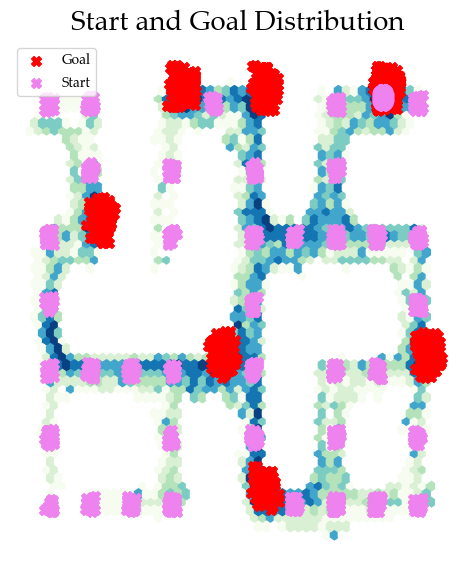

In [22]:
from cProfile import label
from numpy import size


val_x, val_y, train_x, train_y = sample_data_balanced(x, y, sample_ratio=1)
print(f"{len(val_x)}, {len(val_y)}, {len(train_x)}, {len(train_y)}")

# Define the colormap
cmap = plt.cm.GnBu
cmap.set_under("white")

# Calculate statistics and plot for validation data
val_stats = calculate_statistics(val_x, val_y)
val_bounds = np.array(val_stats)[1:]
val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

# for ratio in [0.1, 0.25, 0.5, 0.8]:
ratio = 0.5
val_x, val_y, train_x, train_y = sample_data_balanced(x, y, sample_ratio=ratio)
g = sns.jointplot(x=val_x, y=val_y, kind="hex", space=0.0, gridsize=50, cmap=cmap, norm=val_norm, marginal_ticks=False)
g.fig.subplots_adjust(top=1.1)
# g.ax_joint.tick_params(axis='both', direction='in')
# Remove ticks
g.ax_joint.xaxis.set_ticks_position('none') 
g.ax_joint.yaxis.set_ticks_position('none')
# Draw border around the entire grid
# for spine in g.ax_joint.spines.values():
    # spine.set_visible(True)
g.ax_joint.axis('off')
g.ax_marg_x.remove()
g.ax_marg_y.remove()

plt.scatter(gx, gy, color="red", s=50, marker="X", label="Goal")
plt.scatter(start_x, start_y, color="violet", s=50, marker="X", label="Start")
plt.legend()

g.fig.suptitle("Start and Goal Distribution", size=20, x=0.45)
plt.savefig(f"antmaze_play_start_goal_distributions.png", bbox_inches='tight')

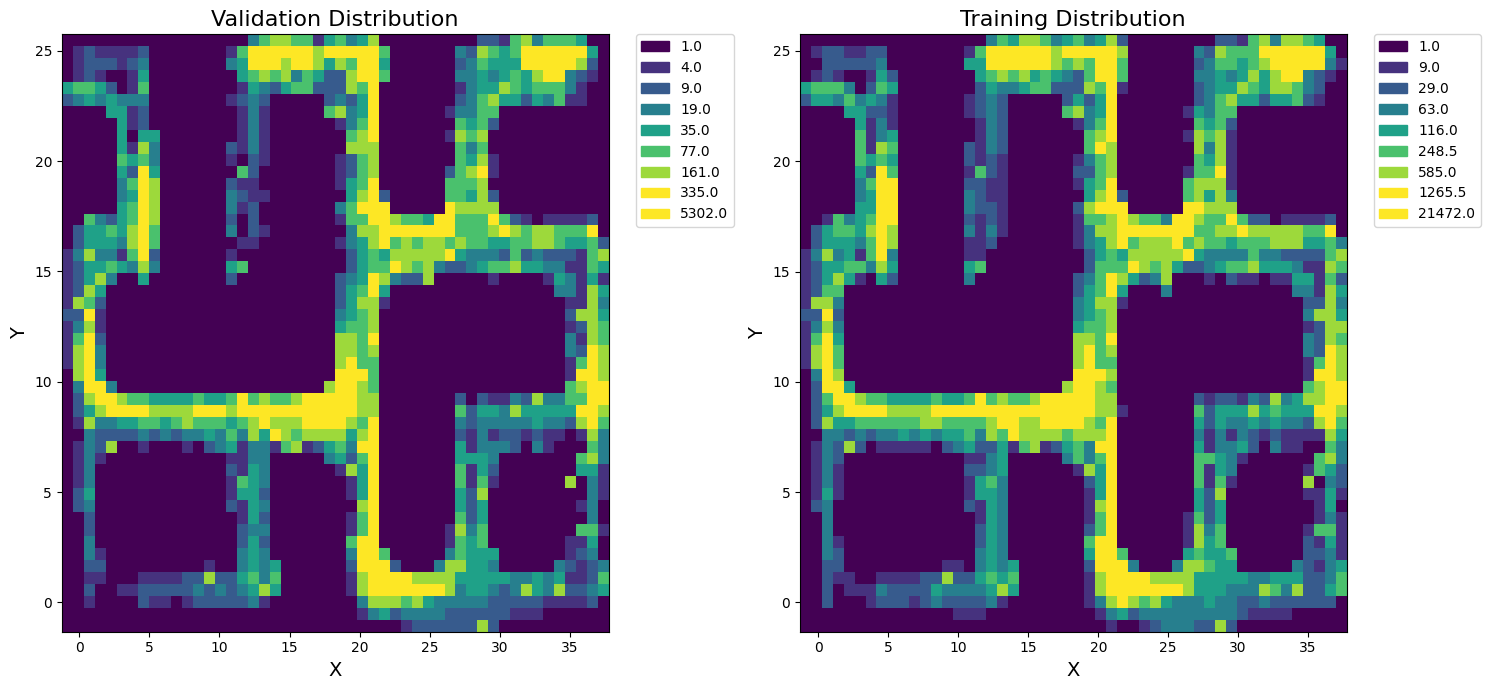

In [31]:
# Define the colormap
cmap = plt.cm.viridis

# Create a figure with two subplots side by side, adjust the size of the graph
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Calculate statistics and plot for validation data
val_stats = calculate_statistics(val_x, val_y)
val_bounds = np.array(val_stats)
val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

# Plot the sampled distribution
h = axs[0].hist2d(val_x, val_y, bins=50, cmap=cmap, norm=val_norm)
# Increase the font size of the title and labels
axs[0].set_title("Validation Distribution", fontsize=16)
axs[0].set_xlabel("X", fontsize=14)
axs[0].set_ylabel("Y", fontsize=14)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(val_norm(stat)), label=stat) for stat in val_stats]

# Add the legend to the plot
axs[0].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Calculate statistics and plot for training data
train_stats = calculate_statistics(train_x, train_y)
train_bounds = np.array(train_stats)
train_norm = mcolors.BoundaryNorm(train_bounds, cmap.N)

# Plot the remaining distribution
h = axs[1].hist2d(train_x, train_y, bins=50, cmap=cmap, norm=train_norm)
# Increase the font size of the title and labels
axs[1].set_title("Training Distribution", fontsize=16)
axs[1].set_xlabel("X", fontsize=14)
axs[1].set_ylabel("Y", fontsize=14)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(train_norm(stat)), label=stat) for stat in train_stats]

# Add the legend to the plot
axs[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

155196, 155196, 844804, 844804


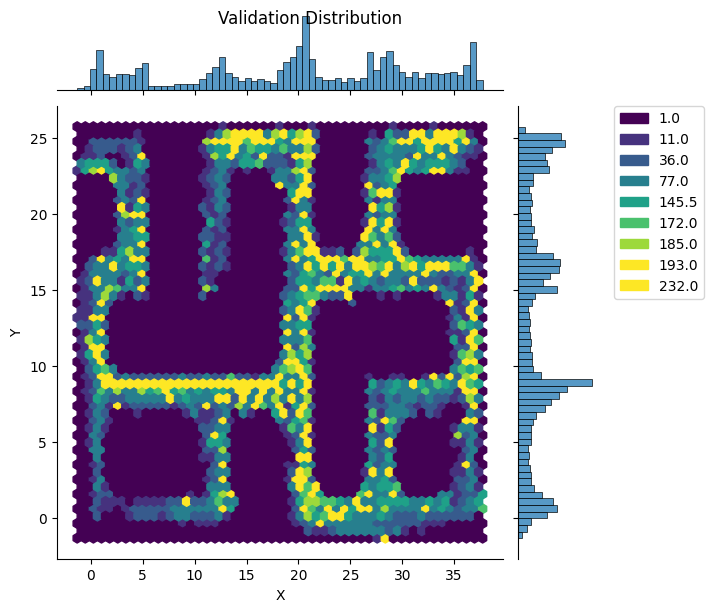

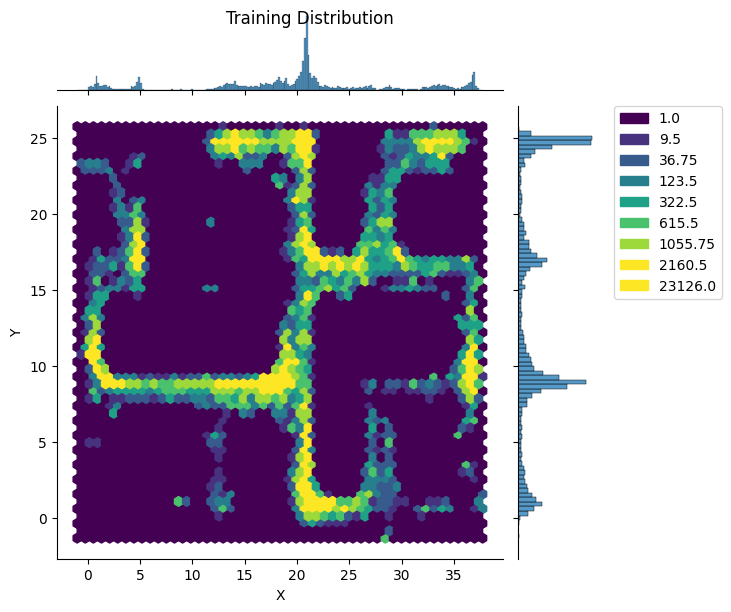

In [32]:
val_x, val_y, train_x, train_y = sample_data_uniform(x, y)
print(f"{len(val_x)}, {len(val_y)}, {len(train_x)}, {len(train_y)}")

# Define the colormap
cmap = plt.cm.viridis

# Calculate statistics and plot for validation data
val_stats = calculate_statistics(val_x, val_y)
val_bounds = np.array(val_stats)
val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

# Plot the sampled distribution
g = sns.jointplot(x=val_x, y=val_y, kind="hex", gridsize=50, cmap=cmap, norm=val_norm)
g.fig.suptitle("Validation Distribution")
g.set_axis_labels("X", "Y")

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(val_norm(stat)), label=stat) for stat in val_stats]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

# Calculate statistics and plot for training data
train_stats = calculate_statistics(train_x, train_y)
train_bounds = np.array(train_stats)
train_norm = mcolors.BoundaryNorm(train_bounds, cmap.N)

# Plot the remaining distribution
g = sns.jointplot(x=train_x, y=train_y, kind="hex", gridsize=50, cmap=cmap, norm=train_norm)
g.fig.suptitle("Training Distribution")
g.set_axis_labels("X", "Y")

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(train_norm(stat)), label=stat) for stat in train_stats]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)

plt.show()

# For visualization of created datasets

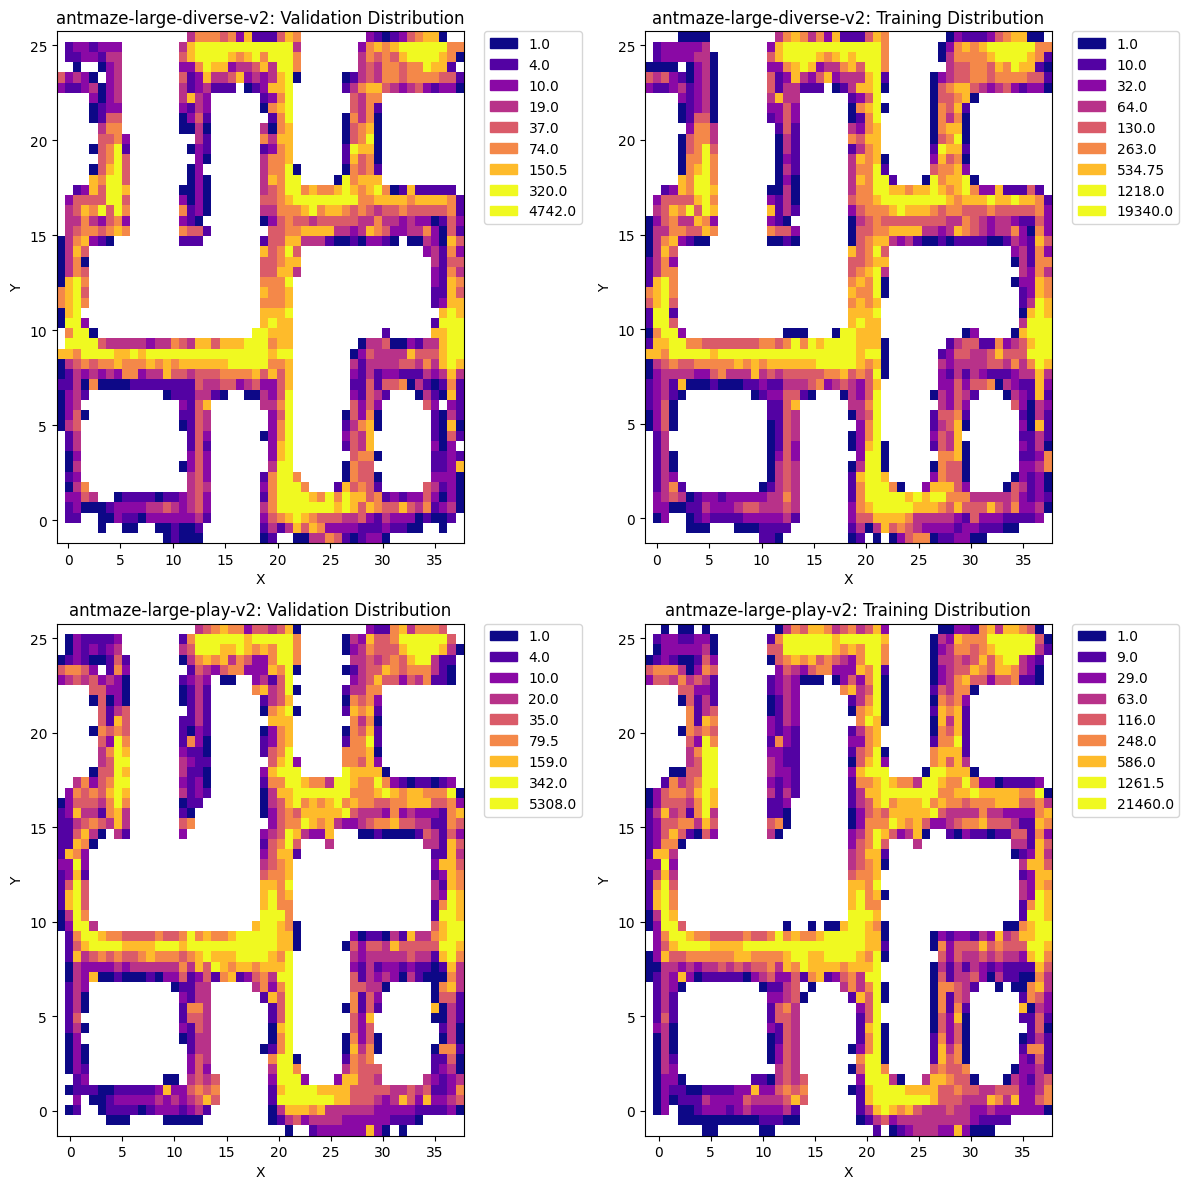

In [49]:
env_names = ["antmaze-large-diverse-v2", "antmaze-large-play-v2"]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, env_name in enumerate(env_names):
    model_train_dir = f"/share/portal/jlr429/pessimistic-irl/LAMPS-IRL/MujocoSysID/model_train_dir/{env_name}"
    train_dataset = np.load(Path(model_train_dir) / "dataset_80_20" / "train.npz")
    val_dataset = np.load(Path(model_train_dir) / "dataset_80_20" / "val.npz")

    val_x, val_y = val_dataset["observations"][:, 0], val_dataset["observations"][:, 1]
    train_x, train_y = train_dataset["observations"][:, 0], train_dataset["observations"][:, 1]

    # Define the colormap
    cmap = plt.cm.get_cmap("plasma").copy()
    cmap.set_under(color='white')

    # Calculate statistics and plot for validation data
    val_stats = calculate_statistics(val_x, val_y)
    val_bounds = np.array(val_stats)
    val_norm = mcolors.BoundaryNorm(val_bounds, cmap.N)

    # Plot the sampled distribution
    h = axs[i, 0].hist2d(val_x, val_y, bins=50, cmap=cmap, norm=val_norm)
    axs[i, 0].set_title(f"{env_name}: Validation Distribution", fontsize=12)
    axs[i, 0].set_xlabel("X", fontsize=10)
    axs[i, 0].set_ylabel("Y", fontsize=10)

    # Create a list of patches for the legend
    patches = [mpatches.Patch(color=cmap(val_norm(stat)), label=stat) for stat in val_stats]
    axs[i, 0].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Calculate statistics and plot for training data
    train_stats = calculate_statistics(train_x, train_y)
    train_bounds = np.array(train_stats)
    train_norm = mcolors.BoundaryNorm(train_bounds, cmap.N)

    # Plot the remaining distribution
    h = axs[i, 1].hist2d(train_x, train_y, bins=50, cmap=cmap, norm=train_norm)
    axs[i, 1].set_title(f"{env_name}: Training Distribution", fontsize=12)
    axs[i, 1].set_xlabel("X", fontsize=10)
    axs[i, 1].set_ylabel("Y", fontsize=10)

    # Create a list of patches for the legend
    patches = [mpatches.Patch(color=cmap(train_norm(stat)), label=stat) for stat in train_stats]
    axs[i, 1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()